In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('D2.csv', na_filter=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36183 entries, 0 to 36182
Data columns (total 29 columns):
race                        36183 non-null object
gender                      36183 non-null object
age                         36183 non-null object
admission_type_id           36183 non-null int64
discharge_disposition_id    36183 non-null int64
admission_source_id         36183 non-null int64
time_in_hospital            36183 non-null int64
medical_specialty           36183 non-null object
num_lab_procedures          36183 non-null int64
num_procedures              36183 non-null int64
num_medications             36183 non-null int64
number_outpatient           36183 non-null int64
number_emergency            36183 non-null int64
number_inpatient            36183 non-null int64
number_diagnoses            36183 non-null int64
max_glu_serum               36183 non-null object
A1Cresult                   36183 non-null object
metformin                   36183 non-null object
re

In [3]:
df['race'].value_counts()

Caucasian          27776
AfricanAmerican     5764
                     848
Hispanic             806
Other                696
Asian                293
Name: race, dtype: int64

In [4]:
df['age'].value_counts()

[70-80)     8990
[60-70)     8232
[80-90)     6386
[50-60)     6159
[40-50)     3328
[30-40)     1245
[90-100)    1072
[20-30)      561
[10-20)      179
[0-10)        22
               9
Name: age, dtype: int64

In [5]:
df['chlorpropamide'].value_counts()

No        36160
Steady       14
              9
Name: chlorpropamide, dtype: int64

In [6]:
df['age'] = df['age'].replace('', np.nan)
df['chlorpropamide'] = df['chlorpropamide'].replace('', np.nan)
df['race'] = df['race'].replace('', np.nan)

In [7]:
#data pre-processing
df['race'].fillna(df['race'].mode()[0], inplace=True)
df['chlorpropamide'].fillna(df['chlorpropamide'].mode()[0], inplace=True)
df['age'].fillna(df['age'].mode()[0], inplace=True)

In [8]:
age_map = {'[0-10)':1, '[10-20)':2,'[20-30)':3,'[30-40)':4,'[40-50)':5,'[50-60)':6,'[60-70)':7,'[70-80)':8,'[80-90)':9,'[90-100)':10}
df['age'] = df['age'].map(age_map)

In [9]:
A1Cresult_map = {'None':1, 'Norm':2,'>7':3,'>8':4}
df['A1Cresult'] = df['A1Cresult'].map(A1Cresult_map)

In [10]:
df2 = df[[ 'num_medications','number_diagnoses','time_in_hospital','A1Cresult','age']]

X = df2.to_numpy()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
# list to save the clusters and cost
clusters = []
cost_vals = []
rs = 42


# this whole process should take a while
for k in range(2, 10, 2):
    # train clustering with the specified K
    model = KPrototypes(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit_predict(X, categorical=[1])
    
    # append model to cluster list
    clusters.append(model)
    cost_vals.append(model.cost_)

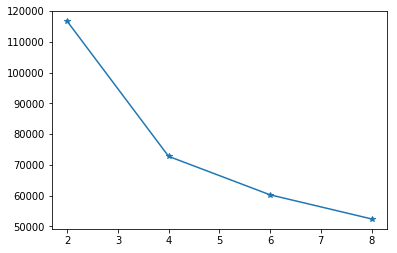

In [12]:
plt.plot(range(2,10,2), cost_vals, marker='*')
plt.show()

In [13]:
X_num = [[row[0], row[1],row[2]] for row in X] # Variables of X with numeric datatype
X_cat = [[row[3], row[4]] for row in X] # variables of X with categorical datatype

In [14]:
model = clusters[1]
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1]), metric='euclidean')
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1]), metric='hamming') 
silScore = (silScoreNums + silScoreCats) / 2
print("The avg Silhouette score for k=4: " + str(silScore))

model = clusters[2]
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1]), metric='euclidean')
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1]), metric='hamming')
silScore = (silScoreNums + silScoreCats) / 2
print("The avg Silhouette score for k=6: " + str(silScore))

The avg Silhouette score for k=4: 0.08483099759819981
The avg Silhouette score for k=6: 0.0414079224453025


C:\Users\86186\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Cluster membership
3    16600
1     8092
2     7064
0     4427
Name: Cluster_ID, dtype: int64


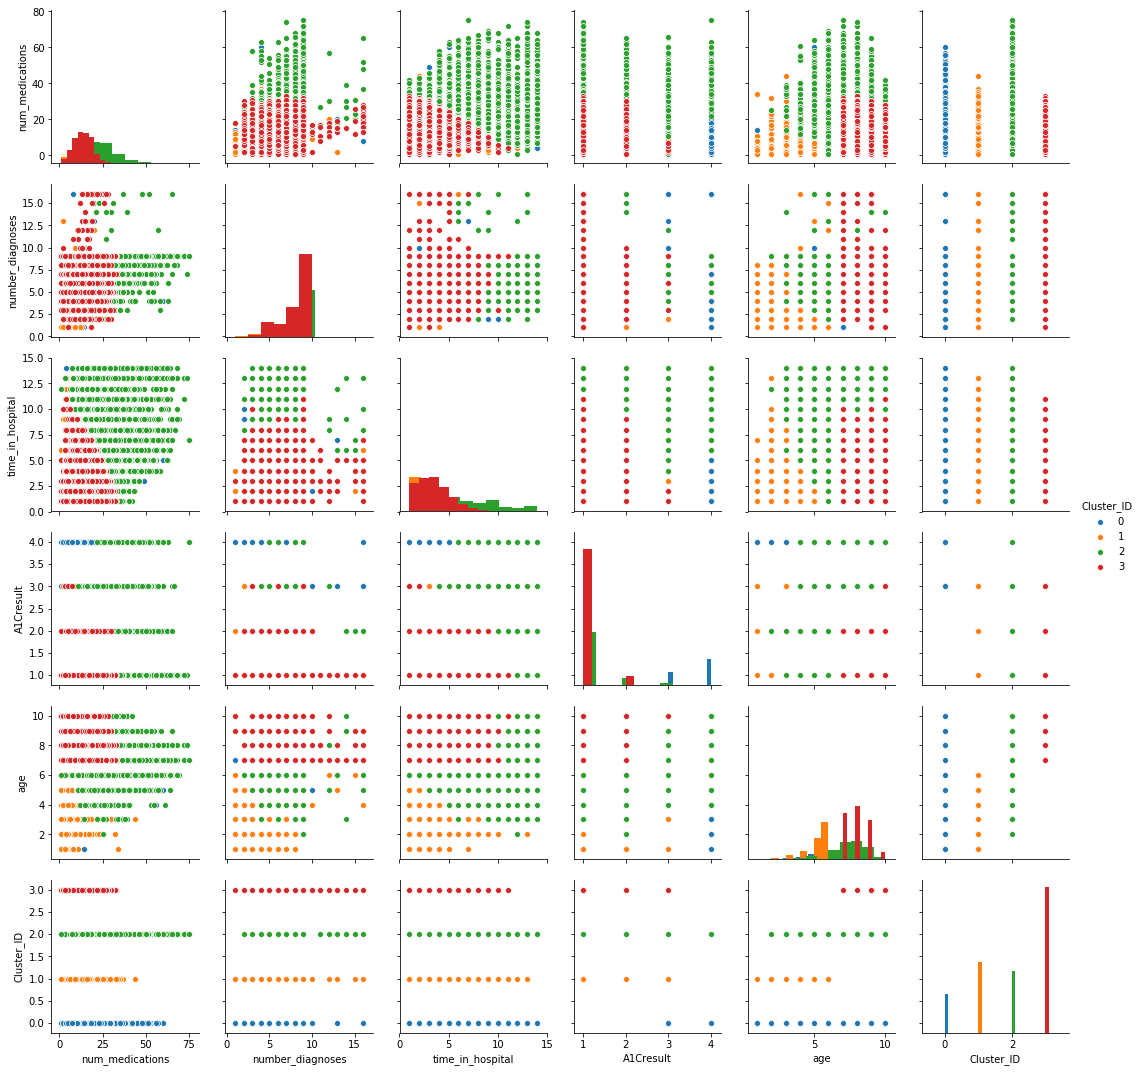

In [15]:
model = clusters[1]
y=model.fit_predict(X, categorical=[1]) 
df2['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())
# pairplot the cluster distribution.
cluster_g = sns.pairplot(df2, hue='Cluster_ID',diag_kind='hist')
plt.show()

Distribution for cluster 0


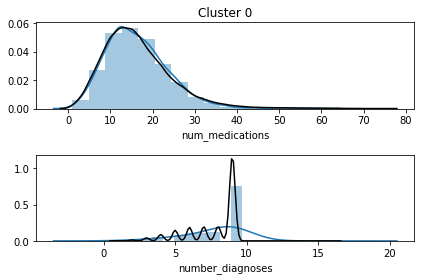

Distribution for cluster 1


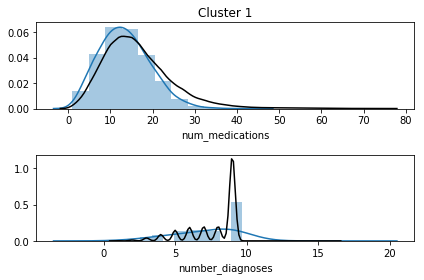

Distribution for cluster 2


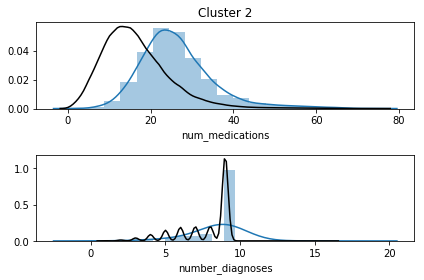

Distribution for cluster 3


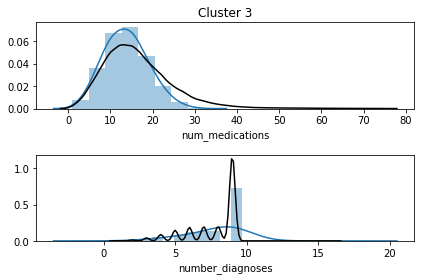

In [35]:
cols = ['num_medications','number_diagnoses']
n_bins = 20


clusters_to_inspect = [0,1,2,3]

for cluster in clusters_to_inspect:
    print("Distribution for cluster {}".format(cluster))
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        bins = np.linspace(min(df[col]), max(df[col]), 20)
        sns.distplot(df2[df2['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True, kde_kws={'bw':1.5})
        sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

Distribution for cluster 0


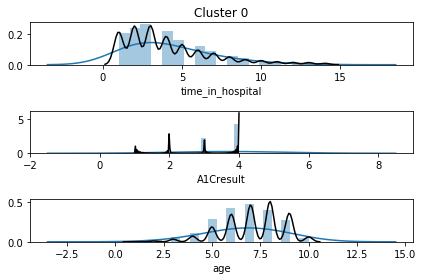

Distribution for cluster 1


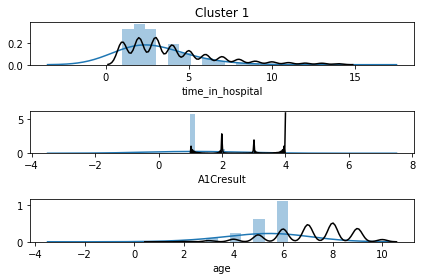

Distribution for cluster 2


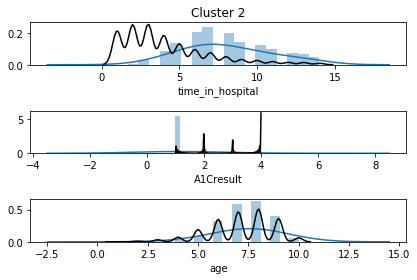

Distribution for cluster 3


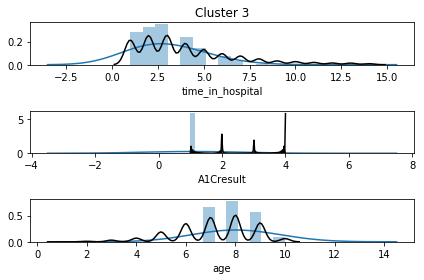

In [36]:
cols = ['time_in_hospital','A1Cresult','age']
n_bins = 10


clusters_to_inspect = [0,1,2,3]

for cluster in clusters_to_inspect:
    print("Distribution for cluster {}".format(cluster))
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        bins = np.linspace(min(df[col]), max(df[col]), 20)
        sns.distplot(df2[df2['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True, kde_kws={'bw':1.5})
        sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

In [37]:
df_nostd = df[['num_medications','number_diagnoses','time_in_hospital','A1Cresult','age']]

X = df_nostd.to_numpy()

C:\Users\86186\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Cluster membership
3    14141
1    12203
2     8069
0     1770
Name: Cluster_ID, dtype: int64


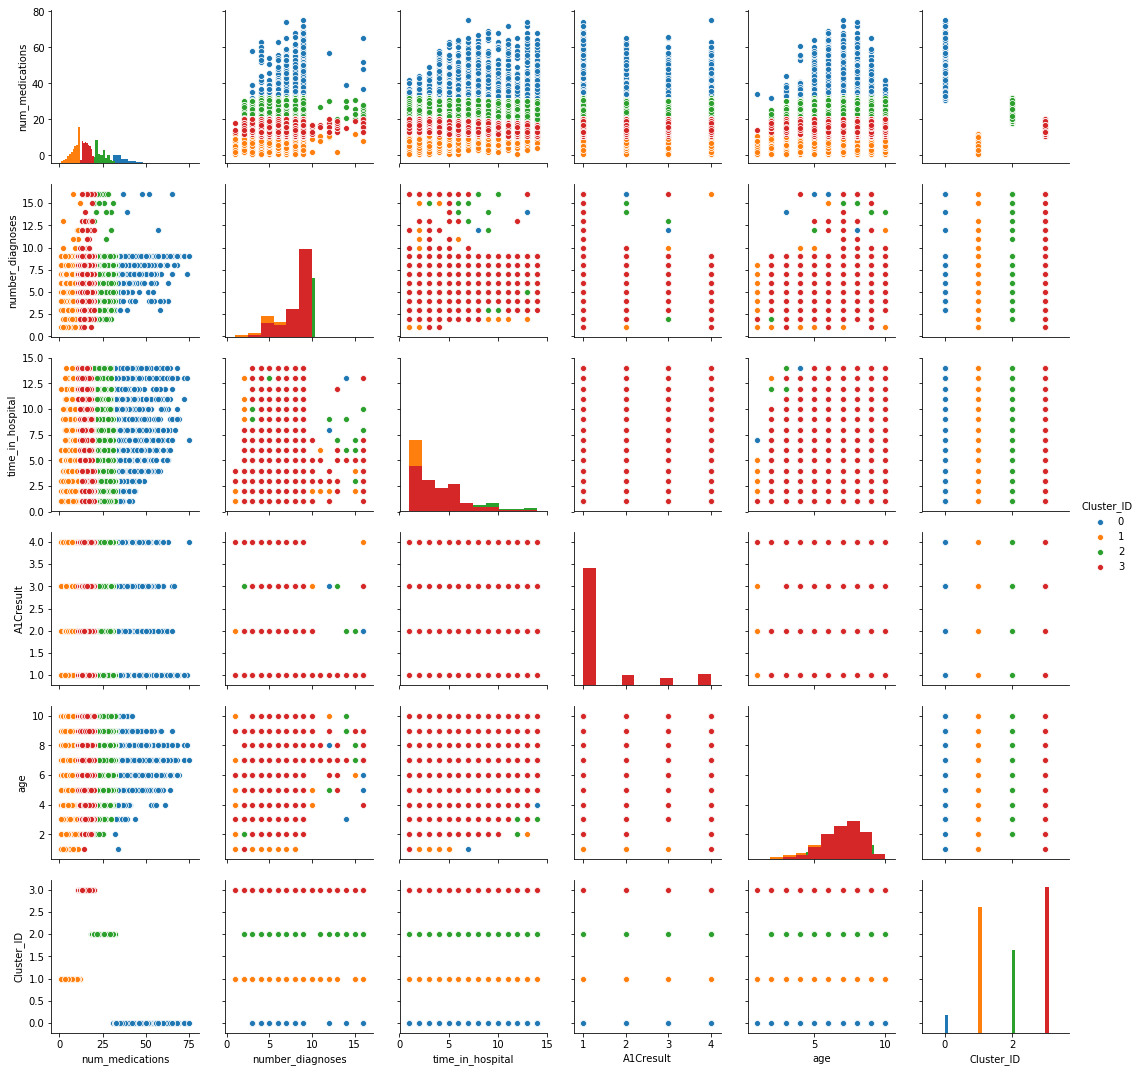

In [38]:
model = KPrototypes(n_clusters=4, random_state=rs, n_jobs=10)
y=model.fit_predict(X, categorical=[1]) 
df_nostd['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df_nostd['Cluster_ID'].value_counts())
# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_nostd, hue='Cluster_ID',diag_kind='hist')
plt.show()

In [39]:
###Q4
df3 = df.loc[(df['race'] == 'Asian') | (df['race'] == 'Caucasian')]
df3

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,insulin,change,diabetesMed
0,Caucasian,Female,7,2,1,1,4,InternalMedicine,43,0,...,No,No,No,No,No,No,No,Steady,False,True
1,Caucasian,Female,9,3,2,1,8,Invalid,48,6,...,No,No,No,No,Steady,No,No,Down,True,True
2,Caucasian,Female,9,2,1,1,2,Cardiology,39,0,...,No,No,No,No,No,No,No,No,False,False
3,Caucasian,Female,7,3,1,1,2,Invalid,54,0,...,No,No,No,No,No,No,No,No,False,False
4,Caucasian,Female,7,3,2,1,7,Invalid,70,1,...,No,No,No,No,No,No,No,Down,True,True
5,Caucasian,Male,8,2,1,7,3,Emergency/Trauma,1,4,...,No,No,No,No,No,No,No,Steady,False,True
6,Caucasian,Male,7,2,1,1,6,Neurology,28,1,...,No,No,No,No,No,Steady,No,Up,True,True
10,Caucasian,Female,8,3,1,1,3,Invalid,27,6,...,Steady,No,No,No,No,No,No,Steady,True,True
12,Caucasian,Male,5,3,1,1,2,Family/GeneralPractice,42,3,...,No,No,No,No,No,No,No,Up,True,True
13,Caucasian,Male,9,1,1,7,3,Invalid,51,0,...,No,No,No,No,No,No,No,No,False,False


In [40]:
# take 3 variables and drop the rest
df3 = df3[['num_medications','number_diagnoses','time_in_hospital','A1Cresult','age']]

# convert df2 to matrix
X = df3.to_numpy()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [41]:
model = KPrototypes(n_clusters=4, random_state=rs, n_jobs=10)
model.fit_predict(X, categorical=[1])

array([0, 2, 3, ..., 2, 3, 3], dtype=uint16)

C:\Users\86186\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cluster membership
0    9988
3    9961
2    5449
1    3519
Name: Cluster_ID, dtype: int64


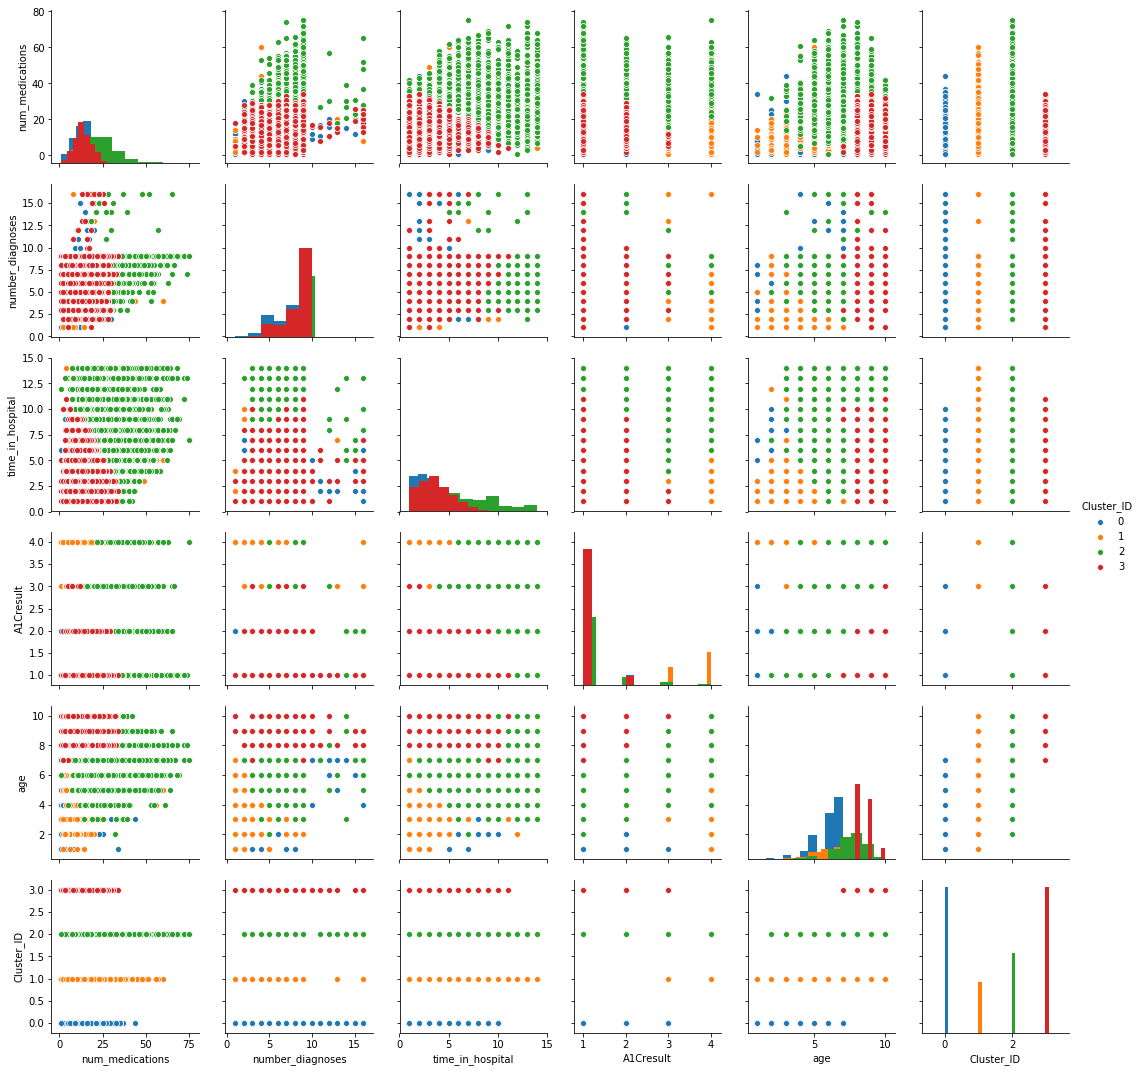

In [42]:
y = model.fit_predict(X, categorical=[1]) 
df3['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df3['Cluster_ID'].value_counts())
# pairplot the cluster distribution.
cluster_g = sns.pairplot(df3, hue='Cluster_ID',diag_kind='hist')
plt.show()

In [43]:
df['race'].value_counts()

Caucasian          28624
AfricanAmerican     5764
Hispanic             806
Other                696
Asian                293
Name: race, dtype: int64